## Importing libraries

In [1]:
import os
import cv2
import tensorflow as tf
import numpy as np
from typing import List
import matplotlib.pyplot as plt
import imageio

In [2]:
physical_devices = tf.config.list_physical_devices('GPU')
try:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
    pass
physical_devices

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## Build data loading functions

In [3]:
# import gdown
# url = 'https://drive.google.com/uc?id=1YlvpDLix3S-U8fd-gqRwPcWXAXm8JwjL'
# output = 'data.zip'
# gdown.download(url, output, quiet=False)
# gdown.extractall('data.zip')

In [4]:
def load_video(path:str) -> List[float]:
    cap = cv2.VideoCapture(path)
    frames = []
    for _ in range(int(cap.get(cv2.CAP_PROP_FRAME_COUNT))):
        ret, frame = cap.read()
        frame = tf.image.rgb_to_grayscale(frame)
        frames.append(frame[190:236, 80:220, :])
    cap.release()
    
    mean = tf.math.reduce_mean(frames)
    std = tf.math.reduce_std(tf.cast(frames, tf.float32))
    return tf.cast((frames - mean), tf.float32) / std

In [5]:
vocab = [x for x in 'abcdefghijklmnopqrstuvwxyz?!123456789 ']
vocab

['a',
 'b',
 'c',
 'd',
 'e',
 'f',
 'g',
 'h',
 'i',
 'j',
 'k',
 'l',
 'm',
 'n',
 'o',
 'p',
 'q',
 'r',
 's',
 't',
 'u',
 'v',
 'w',
 'x',
 'y',
 'z',
 '?',
 '!',
 '1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 ' ']

In [6]:
char_to_num = tf.keras.layers.StringLookup(vocabulary=vocab, oov_token="")
num_to_char = tf.keras.layers.StringLookup(vocabulary=char_to_num.get_vocabulary(),
                                           oov_token="",
                                           invert=True
                                          )

print(f"The vocabulary is : {char_to_num.get_vocabulary()}"
      f"(size ={char_to_num.vocabulary_size()} )")

The vocabulary is : ['', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '?', '!', '1', '2', '3', '4', '5', '6', '7', '8', '9', ' '](size =39 )


In [7]:
char_to_num(['a', 'd', 'e', 'g'])

<tf.Tensor: shape=(4,), dtype=int64, numpy=array([1, 4, 5, 7], dtype=int64)>

In [8]:
num_to_char([1, 4, 5, 7])

<tf.Tensor: shape=(4,), dtype=string, numpy=array([b'a', b'd', b'e', b'g'], dtype=object)>

In [9]:
def load_alignments(path:str) -> List[str]:
    with open(path, 'r') as f:
        lines = f.readlines()
    tokens = []
    for line in lines:
        line = line.split()
        if line[2] != 'sil':
            tokens = [*tokens, ' ', line[2]]
    return char_to_num(tf.reshape(tf.strings.unicode_split(tokens, input_encoding='UTF-8'),(-1)))[1:]

In [10]:
def load_data(path: str):
    path = bytes.decode(path.numpy())
    print('path', path)
    file_name = path.split('\\')[-1].split('.')[0]
    video_path = os.path.join('data', 's1', f'{file_name}.mpg')
    alignment_path = os.path.join('data', 'alignments', 's1', f'{file_name}.align')
    frames = load_video(video_path)
    alignments = load_alignments(alignment_path)
    return frames, alignments

In [11]:
path = ".\\data\\s1\\bbaf2n.mpg"

In [12]:
tf.convert_to_tensor(path).numpy().decode('utf-8').split('/')[-1].split('.')[0]

''

In [13]:
frames, alignments = load_data(tf.convert_to_tensor(path))

path .\data\s1\bbaf2n.mpg


In [14]:
frames[38]

<tf.Tensor: shape=(46, 140, 1), dtype=float32, numpy=
array([[[1.4991663 ],
        [1.4991663 ],
        [1.4991663 ],
        ...,
        [0.3373124 ],
        [0.29983324],
        [0.3373124 ]],

       [[1.4991663 ],
        [1.4991663 ],
        [1.4991663 ],
        ...,
        [0.3373124 ],
        [0.3373124 ],
        [0.3373124 ]],

       [[1.4616871 ],
        [1.4616871 ],
        [1.4242079 ],
        ...,
        [0.3373124 ],
        [0.3373124 ],
        [0.3373124 ]],

       ...,

       [[0.97445804],
        [0.97445804],
        [0.97445804],
        ...,
        [0.        ],
        [0.        ],
        [0.        ]],

       [[0.97445804],
        [0.97445804],
        [0.97445804],
        ...,
        [0.        ],
        [0.        ],
        [9.557184  ]],

       [[0.97445804],
        [0.97445804],
        [0.97445804],
        ...,
        [0.        ],
        [9.557184  ],
        [9.557184  ]]], dtype=float32)>

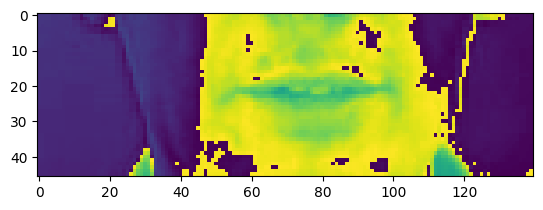

In [15]:
plt.imshow(frames[38])

In [16]:
alignments

<tf.Tensor: shape=(21,), dtype=int64, numpy=
array([ 2,  9, 14, 38,  2, 12, 21,  5, 38,  1, 20, 38,  6, 38, 20, 23, 15,
       38, 14, 15, 23], dtype=int64)>

In [17]:
tf.strings.reduce_join(([bytes.decode(x) for x in num_to_char(alignments.numpy()).numpy()]))

<tf.Tensor: shape=(), dtype=string, numpy=b'bin blue at f two now'>

In [18]:
def mappable_function(path:str) -> List[str]:
    result = tf.py_function(load_data, [path], (tf.float32, tf.int64))
    return result

## Data Pipeline

In [19]:
data = tf.data.Dataset.list_files('./data/s1/*.mpg')
data = data.shuffle(500)
data = data.map(mappable_function)
data = data.padded_batch(2, padded_shapes=([75, None, None, None], [40]))
data = data.prefetch(tf.data.AUTOTUNE)

In [20]:
frames, alignment = data.as_numpy_iterator().next()

path .\data\s1\brwt5s.mpg
path .\data\s1\pgbk8p.mpg
path .\data\s1\lrwl5s.mpg


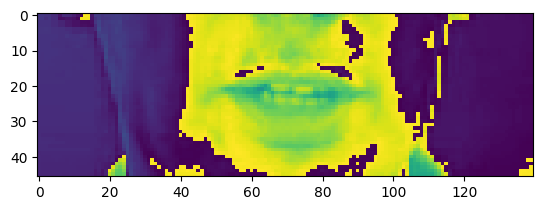

In [21]:
plt.imshow(frames[0][40])

In [22]:
alignment

array([[ 2,  9, 14, 38, 18,  5,  4, 38, 23,  9, 20,  8, 38, 20, 38,  6,
         9, 22,  5, 38, 19, 15, 15, 14,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0],
       [16, 12,  1,  3,  5, 38,  7, 18,  5,  5, 14, 38,  2, 25, 38, 11,
        38,  5,  9,  7,  8, 20, 38, 16, 12,  5,  1, 19,  5,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0]], dtype=int64)

In [23]:
test = data.as_numpy_iterator()
val = test.next(); val[0]

path .\data\s1\pbiu8n.mpg
path .\data\s1\brba1a.mpg
path .\data\s1\pbwp6n.mpg


array([[[[[1.3860804 ],
          [1.5015872 ],
          [1.4630849 ],
          ...,
          [0.26951563],
          [0.30801788],
          [0.30801788]],

         [[1.5015872 ],
          [1.5400894 ],
          [1.4630849 ],
          ...,
          [0.26951563],
          [0.30801788],
          [0.30801788]],

         [[1.5015872 ],
          [1.5015872 ],
          [1.4630849 ],
          ...,
          [0.3465201 ],
          [0.30801788],
          [0.30801788]],

         ...,

         [[1.0395603 ],
          [1.0010581 ],
          [1.0010581 ],
          ...,
          [0.03850223],
          [0.03850223],
          [0.03850223]],

         [[1.0010581 ],
          [1.0010581 ],
          [1.0010581 ],
          ...,
          [0.03850223],
          [0.03850223],
          [0.03850223]],

         [[1.0010581 ],
          [1.0010581 ],
          [1.0010581 ],
          ...,
          [0.03850223],
          [0.03850223],
          [0.        ]]],


        [[[1.5785

In [29]:
imageio.mimsave('./animation.gif', val[0][1], fps=10)

Lossy conversion from float32 to uint8. Range [0.0, 9.461201667785645]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 9.461201667785645]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 9.461201667785645]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 9.461201667785645]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 9.461201667785645]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 9.461201667785645]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 9.461201667785645]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. R

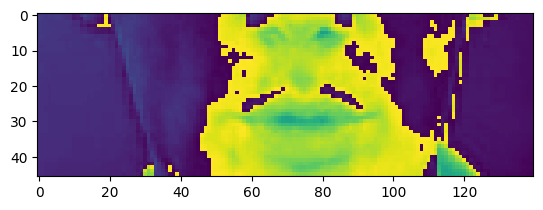

In [37]:
plt.imshow(val[0][1][40])

In [44]:
tf.strings.reduce_join([num_to_char(word) for word in val[1][0]])

<tf.Tensor: shape=(), dtype=string, numpy=b'place blue in u eight now'>

[main 87c9320] Data pipelines is created for loading data
 3 files changed, 1162 insertions(+), 1040 deletions(-)
 create mode 100644 .ipynb_checkpoints/animation-checkpoint.gif
 create mode 100644 animation.gif


To https://github.com/MohammedFarzin/Lip-Net.git
   17857eb..87c9320  main -> main
